# Configuring Rendering Lighting

### tl;dr

This tutorial is about controlling the illumination in your rendered
scenes. The goal is to give you proper intuition and techniques for
efficiently and effectively lighting your scenarios. The goal is to
end up with renderings like this (as rendered
[here](https://carvisualizer.plus360degrees.com/threejs/)):

![PBR-rendered car](images/pbr_car.jpg)
**Figure:** Example of a rendering using RenderEngineVtk PBR rendering.

The discussion is limited to a single rendering technology: physically-
based rendering (PBR). This is available when using `RenderEngineVtk`.
`RenderEngineVtk` also has a legacy Phong illumination model (also
used by `RenderEngineGl`). This tutorial will not discuss the Phong
illumination model. If curious, we recommend further reading on
[Wikipedia](https://en.wikipedia.org/wiki/Phong_reflection_model).

**Tutorial Overview**

  - [Overview of rendering model (PBR)](#what_is_pbr)
  - [Tutorial methodology and infrastructure](#infrastructure)
  - [Direct lighting](#direct_lighting)
    - [Shadows](#shadows)
  - [Materials](#pbr_materials)
  - [Environment maps](#environment_maps)
    - [Tone mapping and exposure](#exposure)
  - [Total illumination](#total-illumination)

<a id="what_is_pbr"></a>
## Physically-based Rendering (PBR)

An illumination model is an approximation of the physics behind the
physical phenomena underlying vision -- electromagnetic radiation
strikes materials and reflects towards a photo-sensitive medium (e.g.,
film, CCDs, human eyes, etc.) The so-called "physically-based rendering"
illumination model is a modern model that hews more closely to actual
physics (in comparison with older, classical illumination models).
While it is truer to reality, it is still an approximation. There
will inevitably be differences between renderings and reality.

### What makes it physical?

PBR has three driving principles:

  - It's based on a microfacet surface model of materials
  - It conserves energy
  - It uses a physically based bidirectional reflection distribution
    function (BRDF).
    - This is a function that models how light reflects off
      surfaces.

PBR provides concrete benefits:

  - It allows content authors to create models based on an object's
    actual properties without concern about how the objects get used;
    the correctness of the material doesn't depend on the lighting.
  - Simply put, it produces more realistic images.
  
To effectively light a scene, you need to understand the properties
of the available light sources _and_ how materials respond to those
light sources. For example, if you have an object painted with
[Vantablack](https://en.wikipedia.org/wiki/Vantablack) shining
more light on the object will not appreciably change your final
image. This tutorial provides a high-level discussion of the material
properties and light sources available to you. If you're interested
about the details of PBR, you might try
[this tutorial](https://learnopengl.com/PBR/Theory) or 
[this documentation of a particular implementation](https://google.github.io/filament/Filament.html).

### Enabling PBR in RenderEngineVtk

The discussions below will be interleaved with interactive examples
where you can explore the parameters discussed. We'll simply start
with how to enable PBR illumination.

`RenderEngineVtk` defaults to the Phong illumination model for
historical reasons. This default will change in the future. In the
meantime, there are three things that will change a `RenderEngineVtk`
instance from Phong to PBR:

  - Explicitly request it in the [`RenderEngineVtkParams`](https://drake.mit.edu/doxygen_cxx/structdrake_1_1geometry_1_1_render_engine_vtk_params.html)
    - Set the `force_to_pbr` flag to `true`.
  - Add an [environment map](#environment-maps).
  - Add a glTF file (Drake's preferred visual geometry representation).

<a id="infrastructure"></a>
## Tutorial methodology and infrastructure

### Methodology

As we discuss the details of PBR and Drake, we'll do it in a context
in which you can explore the parameter space.

In addition to the code blocks in which you can modify parameters and
re-evaluate, we'll grant you the ability to move the camera and
re-render the image. We'll do that via an instance of meshcat
visualizer. By moving the camera in the visualization browser window,
the camera in this session will update its pose to match. It *does*
require explicitly re-rendering.

The pattern you'll see over and over again is a pair of code blocks.
The first will set up the scene -- with particular emphasis on the
parameters being illustrated. It also sets a curated camera pose so
that the first rendering you do will show what the tutorial needs to
show.

The second code block will simply perform the rendering (and contain
the rendered result). The first evaluation will use the camera pose
defined in the first block. Subsequent executions of the rendering
block will use the pose from the meshcat session.

To streamline the first code block, we'll introduce some infrastructure
to admit compact declarations of scenes.

### Infrastructure

The necessary imports.

In [1]:
import copy
import json
import math
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np

from pydrake.common import (
    FindResourceOrThrow,
    MemoryFile,
)
from pydrake.common.value import Value
from pydrake.geometry import (
    Box,
    ClippingRange,
    ColorRenderCamera,
    EnvironmentMap,
    EquirectangularMap,
    FramePoseVector,
    GeometryFrame,
    GeometryId,
    GeometryInstance,
    InMemoryMesh,
    IllustrationProperties,
    LightParameter,
    MakeRenderEngineVtk,
    Mesh,
    Meshcat,
    MeshcatVisualizer,
    PerceptionProperties,
    QueryObject,
    RenderCameraCore,
    RenderEngineVtkParams,
    Rgba,
    SceneGraph,
    Sphere,
    StartMeshcat,
)
from pydrake.math import RigidTransform, RotationMatrix
from pydrake.multibody.parsing import PackageMap
from pydrake.systems.framework import DiagramBuilder, LeafSystem
from pydrake.systems.sensors import (
    CameraInfo,
    ImageRgba8U,
)

We'll create a special system that will track the camera
position in the meshcat session.

In [2]:
class CameraController(LeafSystem):
    def __init__(self, scene_graph, meshcat):
        """The single output port provides a RigidTransform defining the
        pose of the camera body in the world frame: X_WC. The value is defined
        by polling the given Meshcat instance. If the meshcat url includes the
        argument `tracked_camera=on` we'll get the pose of the visualizer's
        camera. Otherwise, we simply return some generic camera position.
        """
        LeafSystem.__init__(self)
        self._meshcat = meshcat
        self._source_id = scene_graph.RegisterSource("camera_controller")
        self._frame_id = scene_graph.RegisterFrame(
            source_id=self._source_id, frame=GeometryFrame("camera"))
        output_cls = Value[FramePoseVector]
        self.DeclareAbstractOutputPort("camera_pose",
                                       lambda: output_cls(),
                                       self.CalcPose)
        # Looking down from above.
        self._default_X_WC = RigidTransform(
            R=RotationMatrix.MakeXRotation(math.pi), p=[0, 0, 5])

    def frame_id(self):
        return self._frame_id

    def source_id(self):
        return self._source_id

    def set_camera_pose(self, pose_in_world=None):
        """Sets the override camera pose."""
        self._X_WC = pose_in_world

    def CalcPose(self, context, pose_vector):
        X_WC = self._X_WC
        if X_WC is None:
            X_WC = self._meshcat.GetTrackedCameraPose()
            if X_WC is None:
                X_WC = self._default_X_WC
        poses = FramePoseVector()
        poses.set_value(id=self._frame_id, value=X_WC)
        pose_vector.set_value(poses)

Now, we'll create the `RenderComparator` class. This class will
allow us to instantiate multiple renderers for a single scene.
When we render from the comparator, each of the render engines
will render a color image, and the comparator will display the
array of images.

It also gives us short-cuts for populating the scene with simple
primitives.

In [3]:
class RenderComparator:
    """Configures a diagram that can produce render comparisons between
    multiple engines. The camera poses will be driven by a provided Meshcat
    instance. Each time the rendering is made, the camera pose is pulled from
    `meshcat`.
    """
    def __init__(self, meshcat):
        self._meshcat = meshcat
        meshcat.Delete("/drake")
        builder = DiagramBuilder()
        self._scene_graph = builder.AddSystem(SceneGraph())
        # Note: we'll be changing render engines a lot. So, rather than declare
        # them in SceneGraph's model, we'll simply wait and add them to the
        # context.
        self._source_id = self._scene_graph.RegisterSource("main")

        MeshcatVisualizer.AddToBuilder(builder, self._scene_graph,
                                       self._meshcat)

        self._cam_controller = builder.AddSystem(
            CameraController(self._scene_graph, self._meshcat))
        builder.Connect(self._cam_controller.GetOutputPort("camera_pose"),
                        self._scene_graph.get_source_pose_port(
                            self._cam_controller.source_id()))

        builder.ExportOutput(self._scene_graph.get_query_output_port(),
                            "query_object")

        self._diagram = builder.Build()
        self._context = self._diagram.CreateDefaultContext()
        # Make sure MeshVisualizer publishes content to meshcat.
        self._diagram.ForcedPublish(self._context)

        self._sg_context = self._scene_graph.GetMyContextFromRoot(self._context)

        self._cameras = []

        # The contents of sphere.gltf -- we'll use it to create variations of a
        # PBR sphere.
        self._ball_count = 0
        self._gltf_supporting_files = {"sphere.bin", FindResourceOrThrow(
                "drake/tutorials/resources/sphere.bin")}
        gltf_path = FindResourceOrThrow(
                "drake/tutorials/resources/sphere.gltf")
        with open(gltf_path) as f:
            self._ball_contents = json.load(f)

    @staticmethod
    def _make_camera(renderer_name):
        """Makes a camera referencing the given `renderer_name`."""
         # This matches the default Meshcat vertical field of view.
        fov_y = 75 / 180 * math.pi
        core = RenderCameraCore(
            renderer_name=renderer_name,
            intrinsics=CameraInfo(width=1024, height=768, fov_y=fov_y),
            clipping=ClippingRange(0.1, 100.0),
            X_BS=RigidTransform())
        return ColorRenderCamera(core=core)

    def pose_camera_once(self,
                         camera_in_world,
                         target_in_world=np.array((0, 0, 0)),
                         up_in_world=np.array((0, 0, 1))):
        """Computes a pose for the camera located at `camera_in_world` (p_WC),
        looking at `target_in_world` (p_WT) with the camera's up direction as
        close to `up_in_world` (up_W) as possible. Passes it to
        set_override_camera_pose(), so this pose will only be valid for the
        next invocation of render().

        The camera looks in the v_CT_W direction. v_CT should not point in the
        same direction as up_W.
        """
        p_WC = np.array(camera_in_world)
        p_WT = np.array(target_in_world)
        up_W = np.array(up_in_world)

        def normalized(v):
            return v / np.linalg.norm(v)

        Cz_W = normalized(p_WT - p_WC)
        # Note: -Cy points goes up in the image.
        Cx_W = normalized(np.cross(-up_W, Cz_W))
        Cy_W = normalized(np.cross(Cz_W, Cx_W))

        X_WC = RigidTransform(RotationMatrix(
                                  R=np.column_stack((Cx_W, Cy_W, Cz_W))),
                              p_WC)
        self.set_override_camera_pose(X_WC)

    def set_override_camera_pose(self, pose_in_world):
        self._cam_controller.set_camera_pose(pose_in_world)

    def visualize(self):
        """Make sure MeshVisualizer publishes content to meshcat. This should be
        called after adding geometry to the scene.
        """
        self._diagram.ForcedPublish(self._context)

    @staticmethod
    def _assign_materials(geometry, diffuse_rgba):
        def set_diffuse_maybe(props):
            if diffuse_rgba is not None:
                props.AddProperty("phong", "diffuse", diffuse_rgba)

        illustration = geometry.mutable_illustration_properties()
        if illustration is None:
            illustration = IllustrationProperties()
            set_diffuse_maybe(illustration)
            geometry.set_illustration_properties(illustration)
        else:
            illustration.UpdateProperty("phong", "diffuse", diffuse_rgba)

        perception = geometry.mutable_perception_properties()
        if perception is None:
            perception = PerceptionProperties()
            set_diffuse_maybe(perception)
            geometry.set_perception_properties(perception)
        else:
            perception.UpdateProperty("phong", "diffuse", diffuse_rgba)

    def add_ground(self):
        """Adds a grey ground."""
        ground = GeometryInstance(X_PG=RigidTransform([0, 0, -0.5]),
                                  shape=Box(20, 20, 1), name="ground")
        self._add_geometry(ground, Rgba(0.4, 0.4, 0.4))

    def _get_sphere_shape(self, pbr_material: dict):
        """Returns a Mesh shape derived from sphere.gltf whose pbr materials is
        updated to reflect the material definition in `pbr_material`."""
        gltf_json = copy.deepcopy(self._ball_contents)
        gltf_json["materials"][0]["pbrMetallicRoughness"] = (
            gltf_json["materials"][0]["pbrMetallicRoughness"] | pbr_material)
        mesh_file = MemoryFile(json.dumps(gltf_json), ".gltf", "sphere.gltf")
        mesh_data = InMemoryMesh(mesh_file=mesh_file,
                                 supporting_files={"sphere.bin": FindResourceOrThrow(
                "drake/tutorials/resources/sphere.bin")})
        return Mesh(mesh_data=mesh_data)

    def add_ball(self, pbr_material={}, position=[0, 0, 1]):
        """Add a "white" ball so we can observe various lighting effects on it.
        If `pbr_material` is None, the ball is a Sphere primitive with Phong
        materials. Otherwise, the pbr_material is applied to the sphere.gltf
        file.

        The ball (sphere with radius = 1) is placed at position, p_WB.
        """
        shape = self._get_sphere_shape(pbr_material)
        ball = GeometryInstance(X_PG=RigidTransform(position),
                                shape=shape, name=f"ball{self._ball_count}")
        self._ball_count += 1
        # When reading the gltf, we don't want to assign a diffuse property.
        self._add_geometry(ball, None)

    def _add_geometry(self, geometry, diffuse_color = Rgba(1,1,1)):
        self._assign_materials(geometry, diffuse_color)
        self._scene_graph.RegisterGeometry(
            context=self._sg_context,
            source_id=self._source_id,
            frame_id=self._scene_graph.world_frame_id(),
            geometry=geometry)

    def set_render_engines(self, renderer_specs):
        """Clears all render engines from the diagram, adding the engines
        implied by the `renderer_specs` (see RenderEngineSpecs below).
        """
        for camera in self._cameras:
            self._scene_graph.RemoveRenderer(self._sg_context,
                                             camera.core().renderer_name())
        assert self._scene_graph.RendererCount(self._sg_context) == 0
        self._cameras.clear()

        for renderer in renderer_specs:
            # We're only doing PBR, so force PBR to true.
            pbr_params = renderer.params | {"force_to_pbr": True}
            self._scene_graph.AddRenderer(
                context=self._sg_context, name=renderer.label,
                renderer=MakeRenderEngineVtk(
                    RenderEngineVtkParams(**pbr_params)))
            self._cameras.append(self._make_camera(renderer.label))

    def render(self):
        """Renders an image for each of the """
        # Bumping the time dirties the dependency tree; CameraController will
        # query for a new camera pose.
        self._context.SetTime(self._context.get_time() + 1)
        query_object = self._diagram.GetOutputPort("query_object").Eval(
            self._context)

        MAX_COLS = 2
        if len(self._cameras) <= MAX_COLS:
           num_cols = len(self._cameras)
           num_rows = 1
        else:
           num_cols = MAX_COLS
           num_rows = int(np.ceil(len(self._cameras) / MAX_COLS))
        width = 7 * num_cols
        height = 5 * num_rows
        fig, ax = plt.subplots(num_rows, num_cols, figsize=(width, height),
                               squeeze=False)
        fig.set_facecolor('white')
        ax = ax.reshape(-1, )
        fig.subplots_adjust(hspace=0.1, left=0.05, right=0.95)

        images = []
        for i, camera in enumerate(self._cameras):
            image = query_object.RenderColorImage(
                camera=camera, parent_frame=self._cam_controller.frame_id(),
                X_PC=RigidTransform())
            ax[i].imshow(image.data)
            ax[i].set_title(camera.core().renderer_name())
            ax[i].set_axis_off()
        for i in range(len(self._cameras), len(ax)):
            ax[i].set_axis_off()
        plt.pause(0.5)

        # Clear any hard-coded camera pose.
        self.set_override_camera_pose(None)


class RenderEngineSpec:
    def __init__(self, label: str, params: dict):
        """Specification for a render engine.
        `label` will be used as the renderer name and the image label.
        `params` is a dictionary that can be used as:
            `RenderEngineVtkParams(**spec).
        """
        self.label = label
        self.params = params

<a id="first-rendering"></a>
## The first rendering

Let's test the infrastructure. We'll see if we can render a simple image.

We'll also start a meshcat instance here. It is typical to do this once at the
beginning of the notebook, and use the same instance throughout.

In order to be able to track the camera's position in the Meshcat session,
you must open the _modified_ url which will print out after executing the
next block.

In [4]:
meshcat = StartMeshcat()
print(f"The URL to enable camera tracking: {meshcat.web_url()}/?tracked_camera=on")

INFO:drake:Meshcat listening for connections at http://localhost:7000


The URL to enable camera tracking: http://localhost:7000/?tracked_camera=on


Once meshcat is up and connected, this block will check to make sure that
camera tracking is properly enabled. If it fails but you're sure that meshcat
is up and running on the correct URL, simply re-evaluate it again until it
reports success.

In [5]:
if meshcat.GetTrackedCameraPose() is None:
   raise RuntimeError(
      f"Make sure you open the URL: {meshcat.web_url()}/?tracked_camera=on")
print("Camera tracking enabled!")

Camera tracking enabled!


### Set up the render framework

The block below is the first block which sets up the rendering. In this
first rendering, we'll instantiate the comparator, populate it with some
geometry, push the geometry to meshcat, configure a `RenderEngine`, and,
finally, pose the camera.

For subsequent renderings, we may not do all of these (for example, several
renderings in a can use the same geometry).

In [6]:
comparator = RenderComparator(meshcat)

# Add some geometry to the scene.
comparator.add_ground()
comparator.add_ball()

# Make sure we push the geometry to the meshcat browser session.
comparator.visualize()

# Configure a single, default render engine.
default_params = {}
comparator.set_render_engines([RenderEngineSpec("First Rendering", default_params)])

# The *next* invocation of render will use *this* pose. Subsequent invocations
# will pull the pose from meshcat.
# Look at the ball and ground from above.
comparator.pose_camera_once(camera_in_world=[0, 0, 5],
                            target_in_world=[0, 0, 0],
                            up_in_world=[0, 1, 0])

### Invoke rendering

In the meshcat visualizer, you should now see a white sphere on a grey
plane (well, large, flat box). Evaluating the next block should _render_ an
image of the same scene and display that image below the code block.

The first rendering is from the camera pose defined above. Subsequent
invocations of `render()` will pull the pose from meshcat visualizer.

Try changing the view in your meshcat session and re-evaluating the next block.
Confirm that the render perspective changes with the visualizer's view. If not,
confirm the block above, testing the camera feedback, prints out "Camera
tracking enabled!"

Practice manipulating the view. You'll probably be doing that a fair amount
during the course of this tutorial.

**ATTENTION**: Expect the rendered image to deviate from what is shown in
the meshcat browser. Meshcat introduces an independent light set from those
defined in the `RenderEngine`. Meshcat also uses a PBR illumination model
so much of what is described for `RenderEngineVtk` will also apply there
although the exact details will differ.

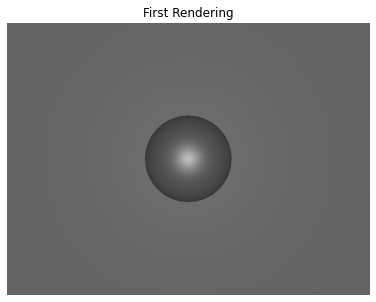

In [7]:
comparator.render()

#### The default light

If no lights are specified (see below), there is a default light: a single
light affixed to the camera. That is why the ball always looks the same,
regardless of how the camera moves. The light is always shining straight ahead
from the camera. However, the ground plane's level of illumination does
change based on the viewing angle.

<a id="direct_lighting"></a>
## Direct Lighting

You can think of virtual lights as objects that emit light energy in rays. The
direction of the rays plays a significant role in how the objects in your scene
get illuminated (see below). Basically, the various light types vary in the
definition of those light rays.

In this section, we'll focus on the *distribution* of light in the scene from
each light type. We won't focus too much on specific reflection effects (that
requires an understanding of [materials](#materials)).

Drake supports three kinds of lights: point, spot, and directional.

  - __Point light__: This is essentially an idealized light bulb. It has zero radius
    so all light rays emanate from a single point. The rays are emitted in all
    directions. Defining the light's `position` determines the emitted light
    rays' common origin and directions.
  - __Spot light__: This is a point light with an opaque, conical light shade on it.
    Like a point light, it emits all light from a single point. However, a
    directed cone limits the directions that rays are emitted. The cone has its
    apex at the light `position` and the cone is rotated so its central axis
    is aligned with the light's `direction` vector (such the cone's radius
    expands in `direction`). Finally, the `cone_angle` controls how narrow the
    spot light's beam is. The angle (in degrees) specifies the _half_ angle of
    the cone's span, or the angle between the cone's central axis and the
    boundary of the cone.
  - __Directional light__: This can be thought of a point light that is infinitely
    far away, or idealized sunlight; all emitted light rays are parallel. As
    such, the directional light has no meaningful value for `position`, but its
    `direction` value defines the direction of the emitted light rays.

![](images/light_types.png)
**Figure:** The three kinds of explicit lights.

### Computing diffuse illumination

Light interacts with matter in various ways. While the physics is fascinating
and intricate, and rendering technology typically focuses on the _effects_ and
creates algorithms that approximate many of the observable effects. The names
you might see in this regard are such things as: "diffuse", "specular",
"ambient", "reflection", "refraction", "diffraction", etc., This tutorial won't
necessarily discuss all supported phenomenon. Instead, it will touch (and
possibly elaborate) on those lighting effects that are most relevant to exploring
the rendering configuration.

#### Diffuse lighting

When light strikes a surfaces, some portion of the light is reflected off of the
surface and some portion is refracted into the surface. The light that refracts
into the surface may bounce around several times before bouncing out again.
The bouncing is a random process. Even though a light ray may strike a surface
from a specific direction, the final refracted light can end up shining in an
arbitrary direction. Thus, from a viewer's perspective, the observed refracted
light doesn't depend on which direction the light ray came from, but simply
how much light struck the surface. Furthermore, the light color and intensity
can be changed by this process (as some frequencies of light get filtered out
and energy gets absorbed as part of the bouncing around).

To fully account for this refracting phenomenon, we need to add up all of the
light that can strike that surface point from any direction (this is, in fact,
a hemisphere of directions; light rays coming from "behind" the surface point
do not illuminate it). As we sum up all of the light sources and account for
the energy loss and color shifts, we end up with the total refracted light
emitted from the point on the surface.

This process "diffuses" the lighting shining onto the surface, blurring,
tinting, and dimming it from the viewer's perspective. (Note: we'll discuss
the reflected portion down below when we talk about "specular" reflections.)

The question of "how much light" strikes the surface is affected by the
intensity of the light sources and the angle at which the light ray strikes
the surface. A light ray striking the surface perpendicularly will have the
most energy. As the angle becomes shallower, the amount of light striking the
surface will get smaller. This is computed based on the normal of the
illuminated surface and the direction of light rays produced by each light
type.

For a scene with a flat plane, we can see the different diffuse lighting effects
that the three lights have. We'll render a flat plane with three different lights:
a point light 5 meters above the plane, and a spot light 5 meters above the
plane, shining straight down, and a directional light shining directly down on
the plane.

So, let's look at the distribution of light from each light type.

In [8]:
# Three render engines with three different lights. We express the position and
# direction of the lights in the *world* frame; the lights will *not* move with
# the camera.

def make_config(custom_light_params):
    # We'll mix in custom light parameters with these default parameters. Not
    # all parameters will have effect on all light types.
    light = LightParameter(**({"frame": "world",
                               "position": [0, 0, 5],
                               "cone_angle": 50,
                               "direction": [0, 0, -1]
                              } | custom_light_params))
    return {"lights": [light]}

comparator.set_render_engines([
    RenderEngineSpec("Point Light", make_config({"type": "point"})),
    RenderEngineSpec("Spot Light", make_config({"type": "spot"})),
    RenderEngineSpec("Directional Light", make_config({"type": "directional"})),
    ])

# Pick a view above the ground, but not straight down.
comparator.pose_camera_once(camera_in_world=[0, -1, 10])

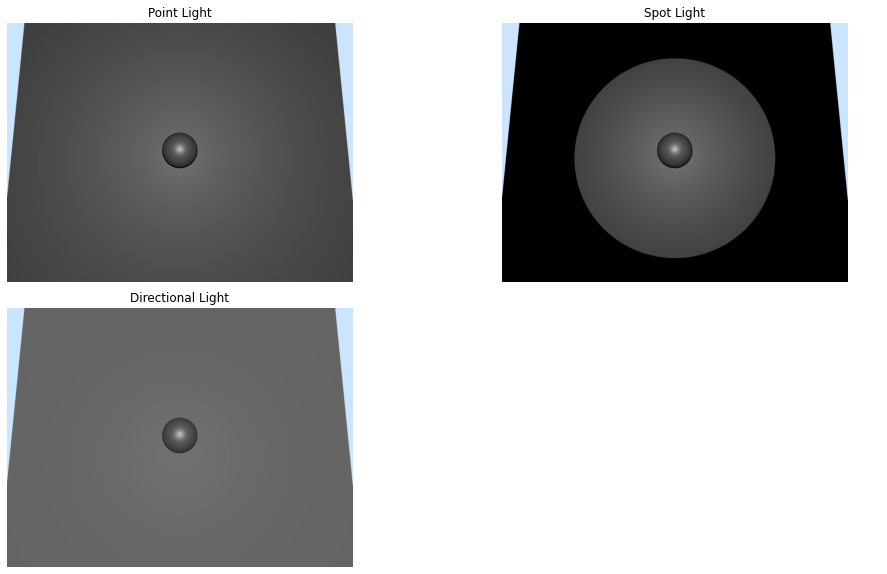

In [9]:
comparator.render()

Don't forget, repeated executions will
[render from your meshcat camera perspective](#meshcat-camera-control).

There are some essential differences between the three images. Let's look at
those differences and see how light choice effects them.

The most obvious difference is the spot light's limit. It doesn't illuminate
the full ground box. We see a circular pool of light. The light is circular
because the spot light's cone of light intersects the ground perpendicularly.
If the spot light were tilted, it the pool of light would be elliptical.
In `RenderEngineVtk`, the spot light's pool of light *always* has a hard edge.

A more subtle difference is between the point light and directional light
images. In both images, the ball's appearance is essentially the same. However,
the ground box is different. With the point light, the ground direclty under
the ball is the most brighly illuminated. Away from the ball, the ground
is much darker. In contrast, the ground box is the same color everywhere
with the directional light. It's also worth pointing out that _within_ the
pool of light, the spot light's pattern of illumination matches the point
light. Where does this difference come from?

In order for a surface to be visible (to eye or camera), light must strike
the surface. The more light that strikes it, the brighter the surface appears.
Three light properties determine the amount of light striking the surface:
direction, intensity and attenuation.

#### Direction

For a beam of light with a fixed energy level, the portion of that
energy that actually reflects off a surface depends on the angle at which
the beam strikes the surface. If the light strikes the surface perpendicular
to the surface, the energy (per unit area) is maximized. As the beam's
approach direction diverges from perpendicular, less energy per unit area
strikes the surface, so there's less to reflect. The surface will appear
dimmer. As the light direction becomes parallel to the surface, the surface
will not be illuminated at all. Obviously, any light beam coming from _behind_
an opaque surface will not illuminate it all.

So, how does that apply to the images above?

[TODO: illustration]

The point light and directional light (and spot light, of course) have the
same intensity. The point light is placed above the ball so that light
striking the top of the ball strikes the ball perpendicularly. Similarly,
the directional light is aimed straight down. That is why the ball in both
images appears more or less identical.

However, as we consider the ground far away from the ball, the relationship
between surface orientation and light direction differs. By definition,
the rays from the directional light are the same throughout the whole scene.
That's why the ground has constant illumination across its visible surface.
However, the direction from surface to point light changes as we move away
from the center; less light is striking those areas because of the shallower
angle.

Try changing the direction of the directional light or the position of the
point light in the previous rendering to see how illumination levels change.

#### Intensity

Intensity is simple to understand. It is simply how much energy is in the
electromagnetic radiation. In
[`LightParameter`](https://drake.mit.edu/doxygen_cxx/structdrake_1_1geometry_1_1render_1_1_light_parameter.html),
the `intensity` controls this energy level (see below). As the light intensity
increases, the amount of energy reaching the camera can exceed the camera's
ability to display. Details are lost as the pixels saturate to white.
Too little intensity, and the image becomes an indistinguishable black blob.

In [10]:
def make_config(intensity):
    light = LightParameter(**{"frame": "world",
                              "intensity": intensity,
                              "type": "point",
                              "position": [0, 0, 4],
                             })
    return {"lights": [light]}

engines = [RenderEngineSpec(f"Intensity = {i}", make_config(i)) for i in [0.25, 1.0, 15.0]]
comparator.set_render_engines(engines)

# Pick a view above the ground, but not straight down.
comparator.pose_camera_once(camera_in_world=[0, -1, 10])

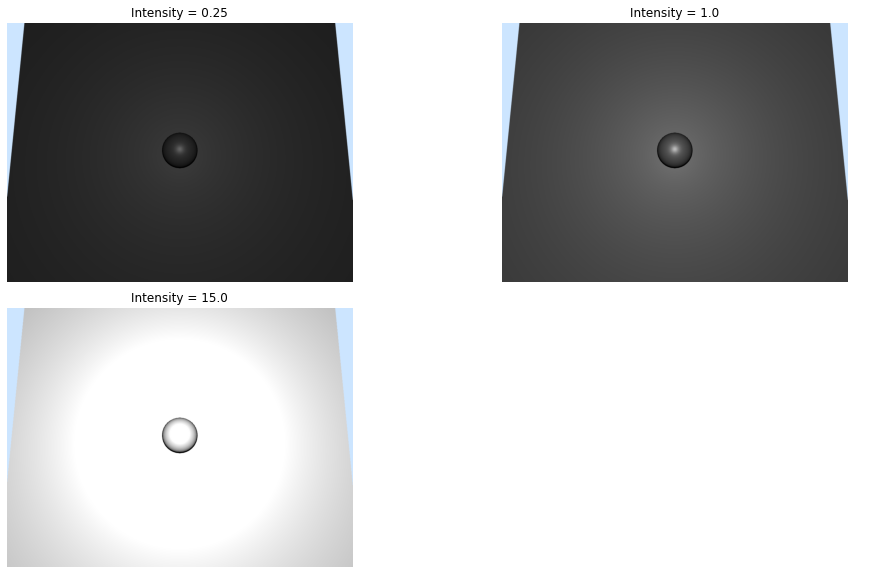

In [11]:
comparator.render()

#### Attenuation

In the real world, light intensity decreases as the distance to the light
increases. This attenuation of the light follows the inverse-squared law --
if distance doubles, intensity falls to a quarter. The lights above have
_no_ attenuation. The distance to the light has no bearing on reflected
intensity. For truly realistic scene lighting, we should change the lights
to have quadratic attenuation.

[`LightParameter`](https://drake.mit.edu/doxygen_cxx/structdrake_1_1geometry_1_1render_1_1_light_parameter.html)
also includes attenuation parameters. It is a tuple of coefficients: (c, l, q).
A light's intensity gets attenuated based on the distance, `d`, between
light source and illuminated point. The scale factor is:

    total_attenuation = 1 / (c + l * d + q * d²)
    
The inverse-squared law is satisified by c = 0, l = 0, q = 1. In practice,
it sometimes becomes convenient to introduce have the intensity decay
more slowly by reintroducing constant or linear factors. The three
coefficients should total one.

**Note**: attenuation does not apply to directional lights as there is
no concept of "distance" with those lights.

In [12]:
def make_config(attenuation):
    light = LightParameter(**{"frame": "world",
                              "intensity": 2,
                              "type": "point",
                              "position": [0, 0, 4],
                              "attenuation_values": attenuation,
                             })
    return {"lights": [light]}

comparator.set_render_engines([
    RenderEngineSpec("Constant", make_config(attenuation=[1, 0, 0])),
    RenderEngineSpec("Linear", make_config(attenuation=[0, 1, 0])),
    RenderEngineSpec("Quadratic", make_config(attenuation=[0, 0, 1])),
    ])

# Pick a view above the ground, but not straight down.
comparator.pose_camera_once(camera_in_world=[0, -1, 10])

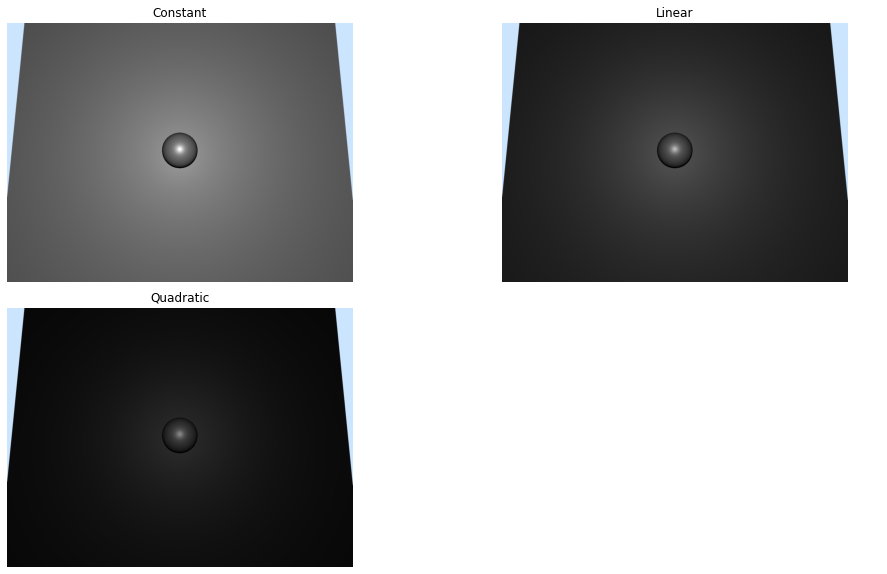

In [13]:
comparator.render()

### Combining lights

A scene can include multiple lights. Sometimes, it is necessary to use multiple
lights to create the final effect of real-world lighting. For `RenderEngineVtk`
you can declare as many lights as you like, although more lights mean greater
computational cost.

In [14]:
# Add several arbitrary light; each with an arbitrarily different color do better
# distinguish the lights.

comparator.set_render_engines([
    RenderEngineSpec(
        "Multiple Lights",
        {"lights": [LightParameter(type="point",
                                   frame="world",
                                   color=Rgba(1, 0, 0),
                                   position=[-2,-2, 1]),
                    LightParameter(type="point",
                                   frame="world",
                                   color=Rgba(0, 1, 0),
                                   position=[-2, 2, 1]),
                    LightParameter(type="point",
                                   frame="world",
                                   color=Rgba(0, 0, 1),
                                   position=[2, 2, 1]),
                    LightParameter(type="point",
                                   frame="world",
                                   position=[2, -2, 1]),
                    LightParameter(type="spot",
                                   frame="world",
                                   color=Rgba(0, 0.8, 0.8),
                                   # Note: the direction vector doesn't have to
                                   # be unit length.
                                   direction=np.array((-1, 0, -1)),
                                   position=[3, 0, 3],
                                   cone_angle=35)
                                   ]}),
    ])

# Pick a view above the ground, but not straight down.
comparator.pose_camera_once(camera_in_world=[0, -1, 6])

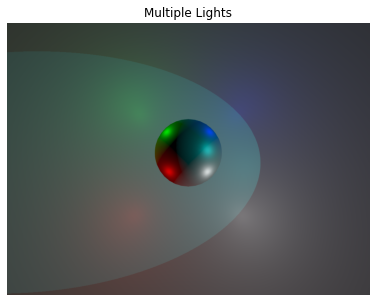

In [15]:
comparator.render()

<a id="shadows"></a>
## Shadows

None of the previous renderings had any shadows. Everything was illuminated as
if there were nothing between the surface and the light. In the real world,
light can be _occluded_. Physical objects block the light, casting shadows onto
surfaces that would otherwise have been lit. In rendering, we don't get
occlusion for free. We create shadows through a variety of approximations. The
spot light's light cone is our first example. In the real world, a spot light's
cone is defined by a physical shade that blocks emitted light. The virtual spot
light is simply modeled as a cone of light directly. However, this simplified
cone model, while sufficient for creating a _pool_ of light, is insufficient for
shadows.

There are multiple techniques to detect occlusion. `RenderEngineVtk` uses a
technique called "shadow maps". Shadow maps are an encoding of surfaces that are
visible *to the light source*. Any surface that is visible gets illuminated.
Surfaces that are not visible are in shadow. A shadow map is a texture map
(hence the name), where every pixel contains a value storing the distance of
the closest surface in the direction of the pixel. These distance measurements
are reconciled at rendering time to determine if a surface is in shadow or not.

Let's explore these phenomena. But first, let's make sure shadows work.

In [16]:
# One renderer casts shadows, one doesn't. Otherwise identical.

def make_config(custom_config):
    config = {"lights": [LightParameter(type="spot",
                                        frame="world",
                                        position=[0, 0, 5],
                                        cone_angle=50,
                                        direction=[0, 0, -1])]}
    return config | custom_config

comparator.set_render_engines([
    RenderEngineSpec("With Shadows", make_config({"cast_shadows": True})),
    RenderEngineSpec("No Shadows", make_config({"cast_shadows": False}))])

comparator.pose_camera_once(camera_in_world=[0, -3, 3])

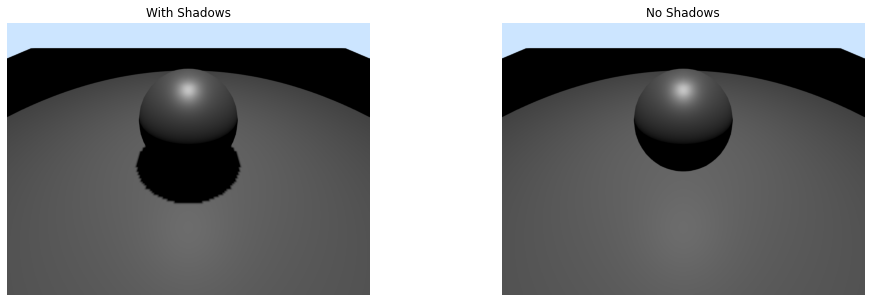

In [17]:
comparator.render()

You should clearly see that the ball casts a shadow on the ground plane in the
image on the left. The image on the right is a repeat from before, but has
*explicitly* disabled shadow casting. If you see the shadow, you can proceed
with the next steps to see how the various settings control the shadow
appearance.

(Keen observers will no doubt notice the pixely edge of the shadow. That topic
is explored below in the "Shadow resolution" section.)

### What lights can cast shadows?

Spot lights and directional lights can cast shadows. Point lights cannot.

The following renderings will enable shadows and each uses a unique light type.
Notice that we've changed the light position (brining the spot and point
lights closer to the ball).

In [18]:
# Each renderer is configured to cast shadows. We've r

# The properties common to all declared lights (some values may
# be ignored -- e.g., cone_angle for point lights).
def make_config(custom_light_params):
   light = LightParameter(**({"frame": "world",
                              "position": [0, 0, 3],
                              "direction": [0, 0, -1],
                              "cone_angle": 50} |
                             custom_light_params))
   return {"lights": [light], "cast_shadows": True}

comparator.set_render_engines([
    RenderEngineSpec("Point Light", make_config({"type": "point"})),
    RenderEngineSpec("Spot Light", make_config({"type": "spot"})),
    RenderEngineSpec("Directional Light", make_config({"type": "directional"})),
    ])

# Pick a view above the ground, but not straight down.
comparator.pose_camera_once(camera_in_world=[0, -2.5, 3.5])

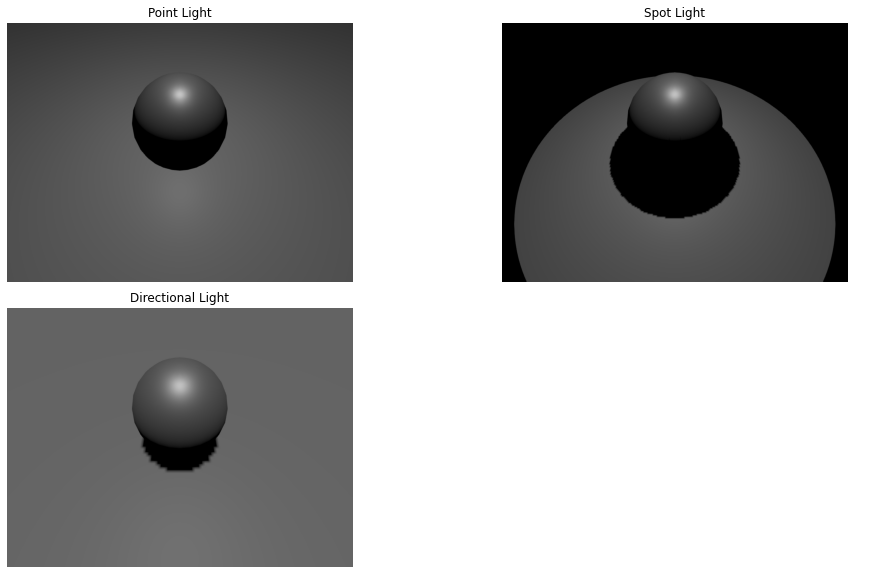

In [19]:
comparator.render()

As promised, the point light casts no shadow on the ground plane. Declaring
`cast_shadows = True` is not an error for point lights; the value simply has no
effect. Conversely, the spot and directional lights both cast shadows, there are
some obvious differences between the shadows.

- The shadow cast from the directional light is smaller than that of the spot
  light Not only that, it even appears smaller than the ball.
   - The directional shadow *is* definitely smaller than the point light shadow.
     Because the spot light's light rays diverge, the shadow will be larger than
     the object casting it. This is illustrated in the figure below in the
     shadow map resolution section.
   - However, the directional shadow is *not* smaller than the ball itself. This
     is an optical illusion due to perspective. The ball's shadow is, in fact,
     the same size as the ball itself. But the shadow is farther from the camera
     than the ball itself. And in perspective, the closer something is, the
     larger it appears. Try moving the camera and re-rendering.
     When the camera is close to the ground, it is clear that the shadow has
     the same radius as the ball.
- The spot light's shadow has a much smoother edge than the directional light.
  The directional light's shadow has a clearly pixelated edge. This is due to
  shadow map resolution (see below).

As a side note, the lighting levels on the ball from the directional light
is now quite different from that of the point and spot lights. We moved the
point and spot lights *closer* to the ball. So, the surface normal direction
and direction to light deviates more quickly along the surface of the ball,
changing the effect of the lighting. If we were to move the spot and point
lights *farther* from the sphere, the effect would quickly become
indistinguishable from the directional light.

#### Spot light limitations

While spot lights can cast shadows, their ability is limited by the
cone half-angle (the `cone_angle` parameter). It can cast shadows with a 
`cone_angle` value *up to* 90 degrees. The following renderings show
how a too-large `cone_angle` eliminates shadows.

In [20]:
# Place a single spot light above the ball and vary the cone angles.

def make_config(custom_light_params):
    light = LightParameter(**{"type": "spot",
                              "frame": "world",
                              "position": [0, 0, 6],
                              "direction": [0, 0, -1]}
                             | custom_light_params)
    return {"lights": [light], "cast_shadows": True}

comparator.set_render_engines([
    RenderEngineSpec("50-degree Spot Light", make_config({"cone_angle": 50})),
    RenderEngineSpec("85-degree Spot Light", make_config({"cone_angle": 85})),
    RenderEngineSpec("90-degree Spot Light", make_config({"cone_angle": 90})),
    ])

# Pick a view above the ground, but not straight down.
comparator.pose_camera_once(camera_in_world=[0, -2.5, 3.5])

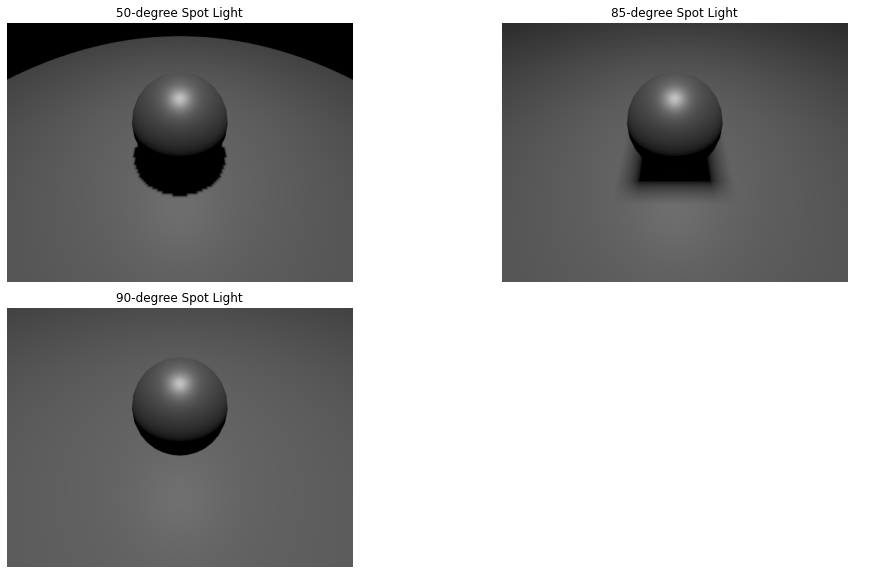

In [21]:
comparator.render()

We get a ball shadow for the 50- and 85-degree spot lights. The 90-degree spot
light casts no shadow.

The reason for this is related to `RenderEngineVtk`'s implementation. It is the
same reason that point lights cast no shadows. The entire space visible to the
light is mapped to a single 2D image via a simple projection. If every possible
shadow a light can cast projects onto a single plane, then that light can
cast shadows. This is true for a spot light with `cone_angle < 90 degrees`. The
plane whose surface normal is parallel with the light's directional vector can
catch all of the shadows. But once the `cone_angle` value reaches 90-degrees,
there are emitted light rays that are *parallel* to that plane. They will
never intersect with the plane and therefore can't cast shadows onto it. In
`RenderEngineVtk`, shadows are simply disabled for such spot lights.

The second thing to note about the images is that the _quality_ of the shadows.
The shadows from the 50-degree spot light and the 85-degree spot light are
obviously different. The shadow from the 85-degree spot light has been reduced
to a single, slightly blurry rectangle. This is a good time to get into shadow
map resolution.

#### Shadow map resolution

The shadow map is a rendering of the scene from the camera's perspective. Each
pixel stores the distance from camera to nearest surface. This makes it closely
resemble a depth map. The following illustration shows a simple scene with a
sphere and box being illuminated by a spot light.

![](images/shadow_map_resolution.png)
**Figure:** Shadow map resolution: the resolution of the shadow map will
determine how much detail is present in the shadow. Too little resolution,
and the blocky shadow map pixels become apparent in the final rendering.

Below the scene are visualizations of possible shadow maps, each with different
resolution. The "Full depth map" represents the idealized shadow map. In this
case, we've colored "far" values as black and "near" values as white. Note that
although the sphere is smaller than the box, because it is closer to the spot
light, it has a larger footprint in the shadow map. This idealized map doesn't
have pixels, *per se*.

The next row down shows a coarse approximation of the idealized map. In this
case, the domain of the shadow map has been reduced to six pixels. The coarse
sampling leads to significant aliasing issues. The extents of the sphere and
box in the shadow map have changed significantly. It is easy to imagine that
for a 3D scene, the shadow of the sphere will be turned into a single square
pixel, just as we observed above from the 85-degree spotlight.

The final row doubles the resolution over the previous row. There are still
sampling artifacts, but the approximation of the actual shadow boundaries has
definitely improved.

Let's look at the `RenderEngineVtkParams::shadow_map_size` parameter and see
its impact on the shadows.

In [22]:
# Compare different levels of shadow resolution.

def make_config(custom_config):
    light = LightParameter(type="spot", frame="world",
                           position=[0, 0, 4], cone_angle=70,
                           direction=[0, 0, -1])
    return {"lights": [light], "cast_shadows": True} | custom_config

engine_params = [
    RenderEngineSpec("128 pixel map - spot", make_config({"shadow_map_size": 128})),
    RenderEngineSpec("256 pixel map - spot", make_config({"shadow_map_size": 256})),
    RenderEngineSpec("512 pixel map - spot", make_config({"shadow_map_size": 512})),
    RenderEngineSpec("1024 pixel map - spot", make_config({"shadow_map_size": 1024})),                     
]

comparator.set_render_engines(engine_params)

# Pick a view above the ground, but not straight down.
comparator.pose_camera_once(camera_in_world=[0, -2.5, 3.5])

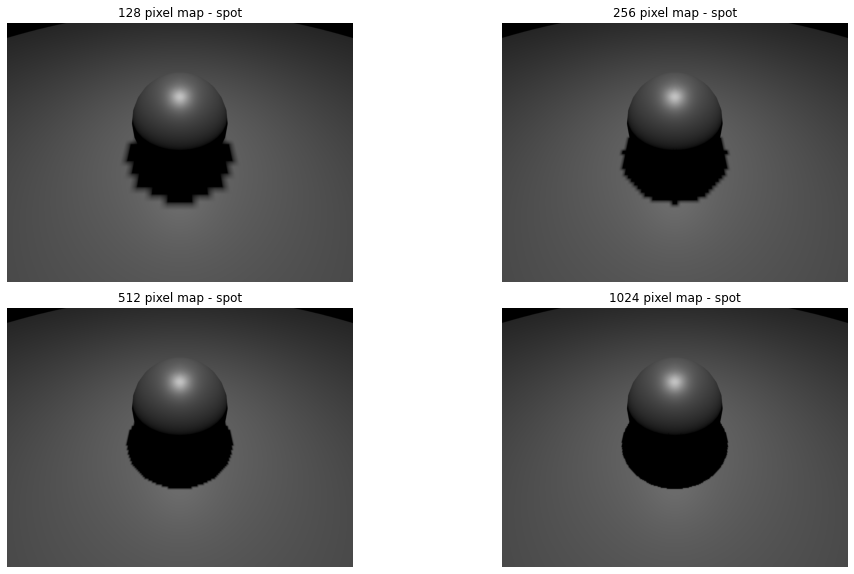

In [23]:
comparator.render()

For a fixed light, we can easily change the shadow map resolution to improve the
visual fidelity of the shadow edges. But this is a setting that needs to be used
judiciously. It would be "safe" to simply set all shadow maps to some large
(power-of-two) value to make sure that shadows all look clean. However, this
comes at a cost. Each shadow map must be re-rendered with each frame. The speed
of this depends on the rendering capability of your computer. It might be
reasonable to *try* setting shadow map resolution high straight across the board
and see if the performance is appreciably harmed. But, generally, the best
strategy is to use the lowest resolution map that provides a visually acceptable
shadow.

#### Shadow map registration

It is one thing to define the resolution of the image that stores the shadow
map. But what is the relationship of that image and the rendered world? In
other words, how big are those pixels? The bigger the pixels, the more likely
you are to notice the resolution.

The shadow map has to be "registered" to the world in some way -- defining which
portion of the world is accounted for by the shadow map. The image is
finite, the world is, in principle, infinite. So, only some *portion* of the
world can be included in the domain of the shadow map. There are no parameters
for controlling this domain of shadow coverage. So, how is it defined?

Both shadow-casting lights have their domains automatically and dynamically
computed on every rendering. At their core, each light determines the extent
of those objects that *can* be illuminated by the light, and registers the
shadow map to cover that full domain.

This domain is updated on a render-by-render basis to prevent objects moving in
and out of regimes in which shadows can be cast. However, it means if the extent
of the scene changes significantly from render to render, the shadows may
qualitatively change as well (e.g., previously smooth shadows become blocky).

Each shadow-casting light uses its own proprietary logic for determining the
illuminated domain.

[TODO: Illustration}

##### Spot light

The spot light's illuminated domain is straightforward. The cone itself defines
the extent of what can be illuminated. As shown in the figure above, the shadow
map simply spans a bounding square of the cone's circular cross-section. It
does mean the corners of the shadow map are wasted (as objects that project
into the shadow map, but outside of the circle don't get illuminated anyways).

##### Directional light

Directional lights don't have finite extent. They can, in principle, cast light
anywhere in the world. In this case, the extent of the illuminated domain is
defined by the extent of the geometry that *can* be illuminated. Essentially, we
create a bounding *cube* around all of the geometry aligned to the directional
light. The size of the cube face is the size of the shadow map in the world.

This means the greater the reach of your geometry, the more shadow map resolution
you need for a directional light. This can come up easily when a ground plane
is added to the scene. Ultimately, the directional light's shadow map will be
stretched to cover the ground plane, even if the objects of interest span a
much smaller domain. To get good shadows on the objects of interest, large
shadow maps must be used.

It is quite common to create a scene, enable the shadows on a *directional*
light and see no shadows cast by or onto your target objects. It may simply be
that the shadow map has been stretched so large, that a shadow map pixel is
larger than your target objects; they simply don't render into the shadow map.

Let's see what that looks like.

In [24]:
# Compare different levels of shadow resolution.

def make_config(custom_config):
    light = LightParameter(type="directional", frame="world",
                           position=[0, 0, 4], cone_angle=70,
                           direction=[0, 0, -1])
    return {"lights": [light], "cast_shadows": True} | custom_config

engine_params = [
    RenderEngineSpec("64 pixel map - directional", make_config({"shadow_map_size": 64})),
    RenderEngineSpec("256 pixel map - directional", make_config({"shadow_map_size": 256})),
    RenderEngineSpec("1024 pixel map - directional", make_config({"shadow_map_size": 1024})),                     
]

comparator.set_render_engines(engine_params)

# Pick a view above the ground, but not straight down.
comparator.pose_camera_once(camera_in_world=[0, -1.5, 2.5])

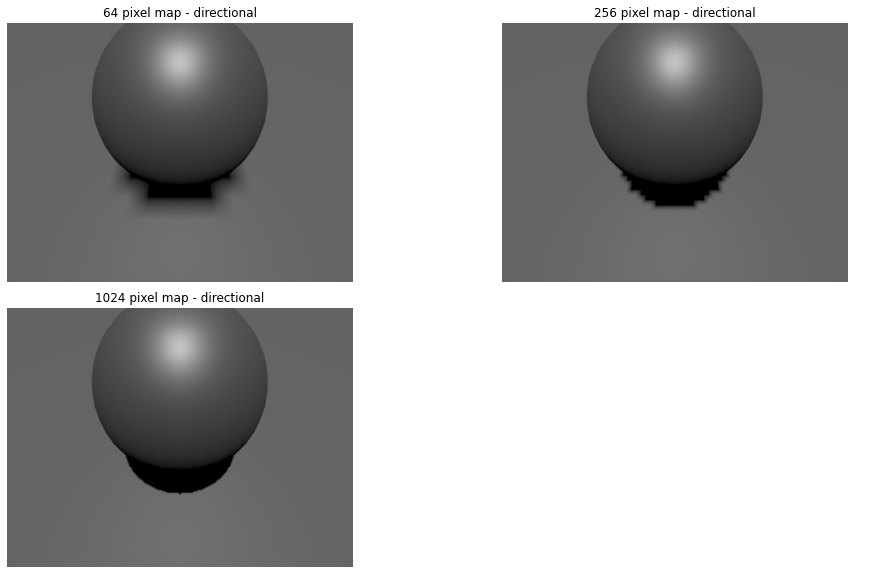

In [25]:
comparator.render()

Given that the light is emitting parallel light rays perpendicularly into the
ground, we would expect the ball's shadow to be the same size as the ball itself.
It is. Given the focal length of our render camera, we're getting strong
perspective effects -- things farther from the camera are scaled smaller than
things closer. When the ball is closer to the camera than its shadow, it will
appear larger. When the shadow is closer to the camera than the ball, the
shadow will appear bigger. THe important thing to note is that these shadows are
both expected and correct.

<a id="pbr_materials"></a>
### PBR Materials

The previous section was all about controlling a source of light (not
the _only_ source of light, more on that [later](#environment_maps)).
However, emitting light is only the start. We're interested in how it
_reflects_ off of surfaces to the camera. To understand that, we need
to talk about how materials are modeled in the PBR model. If you have
the wrong model in your mind, you might be surprised why changing
light properties doesn't have the effect you expect.

Again, this discussion is going bias heavily towards intuition and
principle. Visit one of the links in the introduction to get into the
fine details of the material definitions.

#### Microfacts and reflections

We see **specular** reflections every day. These are the mirror-like
reflections such that images of the environment are visible on the
surface. Even some of the most non-mirror-like surfaces exhibit some
degree of specular reflection -- dull concrete surfaces will still show
highlights when you look at it from the right angle. Take a look at <a href="http://filmicworlds.com/blog/everything-is-shiny/">
this site</a> to see how even the "dullest" objects have specular
reflections.)

The physics of these reflections is conceptually simple. Light strikes a
point on a surface (with an associated surface normal). The incoming
light ray is reflected across the normal. If your eye is on the path of
the outgoing ray, you see the reflected light. Another way of saying the
same thing is to imagine the "half-angle vector" between the incoming
light direction and the outgoing view direction. If that vector is
aligned with the surface normal, you see a reflection.

![simple reflections](images/simple_reflection.png)
**Figure:** The light ray strikes the surface with normal _n_ from
direction _l_. The three views _v₀_, _v₁_, and _v₂_ form half-angle
vectors _h₀_, _h₁_, and _h₂_, respectively. Only _h₁_ aligns with
_n_, so only view _v₀_ receives the specular reflection from the
light source.

In the real world, surface reflectivity can vary widely some crisp
and clear, and others so subtle that you have to look carefully to
notice it. These differences come down to the structure of the object
surface at a microscopic level.

No surface is perfectly smooth. At the microscopic level, irregularties
in the material produce many different normals within a small region.
As light strikes that region, light will get distributed in many
directions simultaneously, based on the distribution of face normal
directions. Shiny surfaces are more regular in structure. The majority
of microfacets face the same way. Dull surfaces have more chaotic
structure. The more coherency in microfacet direction there exists,
the shinier the surface and the more distinct the reflection.

The effect of this is twofold. First, perceived specular
reflections from a highly irregular surface are both dimmer and
blurrier. Dimmer, because the light from a single direction gets
scattered in multiple directions simultaneously; only a small portion
of the incoming light energy from a single direction gets
reflected in the viewer's direction. Blurrier, because the light that
*does* get reflected in the viewer's direction can come from a
larger span of angles.

PBR takes a statistical approach to accounting for these microfacets.
A single rendered pixel may encompass millions of microfacets.
So, in PBR, we describe a surface's "roughness". At any given point
on the surface, there is an attendant roughness value. From this
roughness value, we can determine what portion of the microfacets
are aligned with the half-angle vector, _h_. Let's see what that looks
like.

In [26]:
comparator = RenderComparator(meshcat)

# Add some geometry to the scene.
comparator.add_ground()

# Increasing roughness, from left to right.
test_roughness = [0.05, 0.2, 0.4, 0.6, 0.8, 1.0]
dx = 2.2
start_x = -(len(test_roughness) - 1) * dx / 2
for i, roughness in enumerate(test_roughness):
    comparator.add_ball(pbr_material={"roughnessFactor": roughness},
                        position=[start_x + i * dx, 0, 1])

# Make sure we push the geometry to the meshcat browser session.
comparator.visualize()

comparator.set_render_engines([
    RenderEngineSpec("Varying roughness", {}),
])

# Center on the ball, with it largely filling the frame.
comparator.pose_camera_once(camera_in_world=[0, -5.5, 5.5],
                            target_in_world=[0, 0, 1])

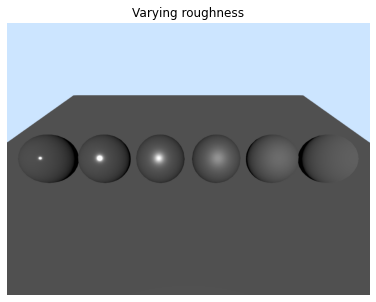

In [27]:
comparator.render()

As roughness increases, the specular reflection of the light grows
larger (i.e. blurrier) and dimmer. This is consistent with PBR's
goal to conserve energy.

##### Clarifications on specular reflections

1. The light sources described above are all, in some sense,
point lights. As the surface gets smoother (roughness going to zero),
the reflection becomes a more exact reflection. Mathematically, when
roughness is zero, the specular reflection of light sources are
mathematical points. These points would *not* appear in the rendering;
the measure of the point is infinitely small. This is correct, with
respect to the PBR model, but counterintuitive when modeling the
physical world. When computing the specular reflection from direct
light sources, Drake uses a minimum roughness value that is greater
than zero. So, do not expect to see differences in how the direct
lights reflect off of surfaces if both surface have roughness values
very close to zero. (Although, the [other light sources](#environment_maps)
will be affected by those small differences).
2. Generally, we will *not* see reflections of other geometries in
a highly reflective material. Getting mirrored surfaces that reflect
other geometry requires a different kind of technique -- one that
`RenderEngineVtk` does not support yet. So, the only specular
reflections we will see are those from scene artifacts that are
considered to be light sources, e.g., the [explicit lights](#direct_lighting)
described above and the [environment maps](#environment_maps) described
below.
3. Specular reflections always depend on three things: the direction the
light ray comes from when striking the surface, the orientation of the
surface (its normal direction), _and_ the direction from the surface to
the camera.
4. When like strikes a surface at a "grazing" angle, the surface exhbits
greater reflectivity (called
[Fresnel reflections](https://en.wikipedia.org/wiki/Fresnel_equations)).

#### Diffuse illumination and "metallness"

Specular reflections come from the light that bounces off a surface.
However, not all light reflects off. Some light refracts into
the surface. Depending on the material, some of the light
bounces around inside a bit, getting filtered by the material,
and bounces out again. This is what makes the surface visible
away from areas of perfect specular reflections.

In contrast to specular reflections, the diffuse illumination
does _not_ depend on the direction from surface to viewer. Diffuse
illumination only depends on the available light sources and the
surface's normal.

PBR models two kinds of materials: metallic and dielectric.
Metallic materials are, as the name implies, made of metal.
Dielectric materials are, more or less, all other non-metallic
materials (e.g., plastic, concrete, wood, glass, etc.).

These two materials behave very differently with respect to
the light.

  - **metallic**
    - Metallic materials absorb _all_ refracted light. That means
      that they don't exhibit _any_ diffuse reflection. Away from
      specular reflections, they are essentially not illuminated.
    - Specular reflections get heavily tinted by the metal's
      intrinsic color (its "albedo"). If you look at gold, copper,
      etc., you'll see the reflections in those materials have
      been tinted to the metal's underlying color.
  - **dielectric**
    - Dielectric materials exhibit diffuse reflection. Light does
      escape from the surface away from the specular reflections.
    - Specular reflections tend to be dimmer than with metallic
      materials (the ratio of how much light gets reflected vs.
      refracted is much lower). Furthermore, the reflections are
      not tinted by the material's albedo.
      
Although, both metallic and dielectric surfaces can display Fresnel
reflections, the effect is typically more noticable on dielectric
materials, because their _base_ reflectivity is generally much lower
than of metals.

In PBR, these two properties are modeled using a "metallic" property
("metallicFactor" in glTF files). In principle, this should be a
binary value; a surface is *either* metallic *or* dielectric.
However, due to interpolation in texture look up, the model handles
all values between zero and one, even if it's not physically
meaningful to say a material is halfway between being metallic and
dielectric.

Let's look at these material differences in play.

In [28]:
comparator = RenderComparator(meshcat)

# Add some geometry to the scene.
comparator.add_ground()

# Two gold-ish smooth-ish spheres; one metallic and one dielectric.
gold_rgba = [1, .71, .29, 1.0]
roughness = 0.2
comparator.add_ball(pbr_material={"baseColorFactor": gold_rgba,
                                  "roughnessFactor": roughness,
                                  "metallicFactor": 1.0},
                    position=[-1.1, 0, 1])
comparator.add_ball(pbr_material={"baseColorFactor": gold_rgba,
                                  "roughnessFactor": roughness,
                                  "metallicFactor": 0.0},
                    position=[1.1, 0, 1])

# Make sure we push the geometry to the meshcat browser session.
comparator.visualize()

comparator.set_render_engines([
    RenderEngineSpec("Metallic vs Dielectric", {}),
])

# Center on the ball, with it largely filling the frame.
comparator.pose_camera_once(camera_in_world=[0, -2.25, 2.25],
                            target_in_world=[0, 0, 1])

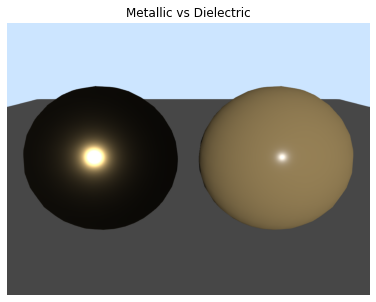

In [29]:
comparator.render()

The two spheres are strikingly different. They both have the
same albedo (underyling color) and roughness values. All of
the differences are attributable to the difference between
metallic and dielectric.

Obviously, the metallic sphere is quite dark, almost like it
isn't being illuminated at all. This is the result of two things
we've discussed. Metallic surfaces only exhibit specular
reflections (never diffuse), and the only scene artifacts that
participate in the specular reflections are light sources; we
won't see the dielectric sphere reflected in the metallic
sphere.

Second, the specular reflection of the light itself differs
across the two spheres. The metallic sphere's "hot spot" is
larger and somewhat oversaturated in the center (we'll deal
with the oversaturatin when we discuss [exposure](#exposure)
later). Again, this is because the metallic surface reflects
a larger portion of the incoming light than the dielectric
surface, so more radiant energy reaches the eye.

Finally, the highlight on the metallic surface has a gold
tint to it, one that the dielectric's highlight is missing.
This is the metallic surface refracting all of the non-gold
light frequencies internally.

Try varying the roughness to see how each material type
changes. Things get particularly interesting when roughness
goes to one.

We'll explore some more differences again in the next section:
[environment maps](#environment_maps).

<a id="environment_maps"></a>
## Environment Maps

The name "environment map" probably invites an intuitive interpretation: a
painted backdrop. Rather than modeling an entire environment, we simply put an
image in the background which we can see directly and reflected in
mirror-like surfaces. While that's true, it's not the whole story. An
environment map is a light source. That means it *will* participate in
specular reflections. But it will also participate in diffuse reflections
as well. Essentially, each pixel in the environment map is a light source
(more on this later).

We'll start with a simple environment map and a mirror ball.

The image below shows a ball in a simple environment. The mirror ball sites on
a gray plane. Around it are three rectangular area lights. Blue and red lights
on either side and a *brighter* white light above it.

![environment_map_scene](images/env_color_room_in_situ.png)
**Figure:** the physical environment.

We can make an environment map by replacing the mirror ball with a panoramic
camera. The panoramic image defines what is visible around a point in all
directions. Essentially, we're painting on the inside of an infinitely
large sphere. But we do so with a rectangular image. The mapping between
the rectangular image and the sphere is an [equirectangular projection](https://en.wikipedia.org/wiki/Equirectangular_projection). The height of
a pixel spans a fixed solid angle of the sphere. The width of a pixel
spans the larget solid angle at the "equator" of the image (central,
horizontal line). But the width of the pixels get smaller as you near
the top and bottom of the image (or north and south poles of the sphere).
We'll make use of this when we attempt to predict the lighting contribution
of the environment map.

![](resources/env_color_room.png)
**Figure:** the environment map drawn from the physical scene shown above.

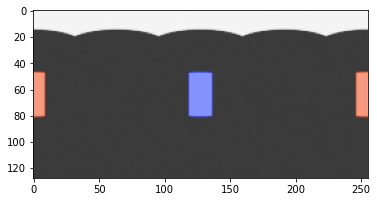

In [30]:
# TODO: Choose between the embedding of the environment map above with this below.

png_path = FindResourceOrThrow("drake/tutorials/resources/env_color_room.png")

png_env_map = cv2.imread(png_path)
plt.imshow(png_env_map)

# Also send the environment map to the meshcat session.
meshcat.SetEnvironmentMap(png_path)

The red and blue lights are easily identified in the image. The top
of the image is the single white area light above the camera. In a
Mercator projection, the north pole gets spread across the full width
of the top of the image. The light directly above the camera has
received the same treatment.

The environment should also have appeared in your meshcat session. Rotate the
camera to see the various light panels. (The image is quite low resolution, so
the light panels should appear as blurry rectangles.) Ultimately, the full
effect of the environment map will be easier to understand when applied to a
scene.

For the next few scenarios, we're going to disable direct light sources
entirely and only look at the effect of the environment map. If you haven't
done so already, you should turn off Meshcat's lights by opening the "Controls"
window an unchecking the blue box next to "Lights". This will bring the
Meshcat window's version closer in line with the renderings in this
tutorial.

We'll use the previous set of gold-ish balls and see the effect the
environment map has on it.

In [31]:
comparator = RenderComparator(meshcat)

# Add some geometry to the scene.
comparator.add_ground()

# Two gold-ish smooth-ish spheres; one metallic and one dielectric.
gold_rgba = [1, .71, .29, 1.0]
roughness = 0.2
comparator.add_ball(pbr_material={"baseColorFactor": gold_rgba,
                                  "roughnessFactor": roughness,
                                  "metallicFactor": 1.0},
                    position=[-1.1, 0, 1])
comparator.add_ball(pbr_material={"baseColorFactor": gold_rgba,
                                  "roughnessFactor": roughness,
                                  "metallicFactor": 0.0},
                    position=[1.1, 0, 1])

# Make sure we push the geometry to the meshcat browser session.
comparator.visualize()

# Add a simple environment map.
comparator.set_render_engines([
    RenderEngineSpec("Mirror Ball",
                     {"environment_map": EnvironmentMap(
                        skybox=True,
                        texture=EquirectangularMap(path=png_path)),
                      # Disable the light; only environment map light in the scene.
                      "lights": [LightParameter(intensity=0)]})])

# Center on the ball, with it largely filling the frame.
comparator.pose_camera_once(camera_in_world=[0, -2.25, 2.25],
                            target_in_world=[0, 0, 1])

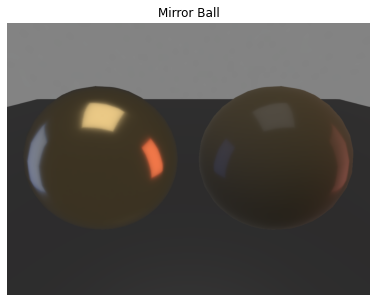

In [32]:
comparator.render()

The metallic sphere is no longer black with a hot spot (as it was
with the single direct point light). This is because the environment
map provides light in every direction, giving the metal surface
something to reflect. Again, all of the reflections have been
tinted the metal's gold-ish albedo color.

Similarly, the dielectric sphere is reflecting the environment.
The specular reflections are dimmer and untinted as before. But
there are some other things going on as well. Let's take a closer
look at how the environment map interacts with dieclectric
materials.

In [33]:
comparator = RenderComparator(meshcat)

# Add some geometry to the scene.
comparator.add_ground()

# This time, we want two white-ish dielectric spheres,
# one smooth, one rough.
comparator.add_ball(pbr_material={"roughnessFactor": 0.1,
                                  "metallicFactor": 0},
                    position=[0, -1.1, 1])
comparator.add_ball(pbr_material={"roughnessFactor": 0.9,
                                  "metallicFactor": 0},
                    position=[0, 1.1, 1])

# Make sure we push the geometry to the meshcat browser session.
comparator.visualize()

# Add a simple environment map.
comparator.set_render_engines([
    RenderEngineSpec("Mirror Ball",
                     {"environment_map": EnvironmentMap(
                        skybox=True,
                        texture=EquirectangularMap(path=png_path)),
                      # Disable the light; only environment map light in the scene.
                      "lights": [LightParameter(intensity=0)]})])

# Center on the ball, with it largely filling the frame.
comparator.pose_camera_once(camera_in_world=[2.25, 0, 2.25],
                            target_in_world=[0, 0, 1])

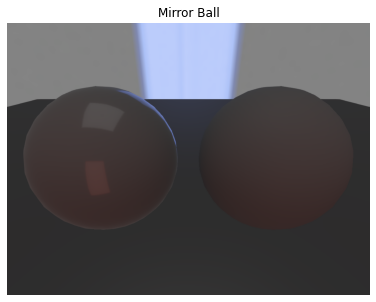

In [34]:
comparator.render()

This time we've put the camera between the two spheres and the
red light in the environment map. We can still clearly see the
specular reflection of the white light and the red light in the
smooth sphere on the left. The rough sphere on the right has no
such specular reflection.

But this image illustrates to additional phenomena: Fresnel
reflections and diffuse illumination.

The Fresnel reflection is apparent in the smooth sphere. We can
see the blue light reflected on the rim of the smooth sphere.
The fact that the sphere reflects the blue light is expected. But
the fact that the reflection of the blue light is more *intense*
than the white or red lights might be surprising. The light striking
the surface at a grazing angle experiences greater reflectivity
so we observe a more intense reflection.

Both spheres have a reddish tint on that covers a large portion
of the side of the sphere. If you move the camera in Meshcat to
look at the blue sides of the spheres and re-render, you'll see
a similar blue tint on the other side. This is the environment
map's contribution to the diffuse lighting effects.

Remember, diffuse illumination when light strikes a surface,
some portion gets refracted _into_ the material, bounces around
and, finally, some remaining portion is emitted again. The
_total_ diffuse affect is the sum of all such light. If
there's a light source that can strike a point on the surface,
it must be included in the diffuse calculation.

In this case, for any givn point on the sphere, fully half of
the environment map is able to shine light onto the sphere
(it is the hemisphere of the environment centered on the
point and arrayed around the surface normal at that point).
Because of the integral and the energy-conserving properties
of the PBR model, the total contribution of the environment
map on the diffuse lighting is a blurred and dimmed version
of the environment.

This effect can also be thought of as a form of "ambient"
lighting. When light is shined into a room, the light doesn't
simply leave the light source and strike a single surface before
bouncing to your eye. The light bounces many, many times. With
each bounce the reflected light can change in character. Light
simply moves so fast that we can't observe this phenomenon; we
merely see the steady state of the light having bounced
everywhere. This is the reason why surfaces can be illuminated
even if the light source can't shine directly onto the surface;
there is "indirect" lighting that does shine onto it. This
indirect lighting is the "ambient" light of the environment.

### High-Dynamic Range (HDR) Images

Not all images can serve equally well as environment maps. A typical image --
one typically seen as part of a webpage -- uses "normalized" color. That means
the value for each pixel is a value in the range [0, 1] (or [0, 255] depending
on encoding). The environment map above uses just such an image. Normalized
color is sufficient for communicating *basic* color information (hue,
saturation, etc.) but it has limited ability to communicate the full _dynamic_
range of radiant _energy_ possible. While physical light has varying frequency
(signalling color in our minds), it also has _intensity_. An ideal environment
map is one that can encode both color _and_ intensity. High-dynamic range (HDR)
images use _unnormalized_ color data. They still communicate color properties
(again, hue, saturation, etc.), but they also encode intensity. The range
between the dimmest and brightest portions of the environment map can be
arbitrarily large (as it is in most human environments). We frequently don't
notice the wide range of intensities because our eyes and brains are good at
taking a wide range of light levels and creating a coherent image in a narrow
range of energy levels. Cameras typically have a smaller dynamic range than
the human optical system, so photographers are always worrying about shutter
speed, film speed, and aperture to control how much light energy the image
medium is exposed to.

This is of critical importance when it comes to curating environment maps.
Environment maps encoded in normalized color images (e.g., png, jpg, bmp, etc.)
will have a different impact on the rendering than an unnormalized color image
(.hdr). In an environment map, a light intensity is associated with each
pixel. Light intensity can be characterized with various units. We'll use
watts (W) as being reasonably correlated with the _brightness_ of the light.
For a normalized image, _every_ pixel, regardless of color, has maximum of 1 W of
energy (for pure white pixels); colors with less value (darker colors) implicitly
have less energy with pure black being the only zero-energy pixel. To put that in
context, in real world scenarios, intensity can range multiple orders of magnitude
between the darkest and brightest light sources. That has two implications for
normalized color images:

  - The maximum intensity of 1 W is quite dim compared to the real world.
  - They provide almost _no_ lighting contrast. What contrast exists usually
    comes from the _colors_ in the image and the general correlation with low
    intensity light sources manifesting as dark colors to film and sensors. As
    counter-intuitive as it might seem, a pixel with normalized color
    (0.01, 0.01, 0.01) image is putting out 1 W of light, just like a white
    pixel. It's just 1 W of essentially "black" light (but not in the "all-night
    rave" sense of the word).

Let's look at the difference between normalized and unnormalized
images.

For the next few experiments, we'll create a small matrix of spheres.
Horizontally, we'll vary smoothness, and vertically we'll vary
material (metallic vs dielectric).

We'll then see the illumination impact of different environment maps.
We'll use the same abstract environment shown above with the same
_color_ information. The maps will differ in their maximum brightness.

  - PNG: a normalized image with brightness of 1 W at each pixel.
  - 7.5 HDR: an HDR image with maximum brightness of 7.5 W.
  - 120 HDR: an HDR image with maximum brightness of 120 W.

In [35]:
# The 7.5 W and 120 W images.
hdr75_path = FindResourceOrThrow("drake/tutorials/resources/env_color_room_75.hdr")
hdr1200_path = FindResourceOrThrow("drake/tutorials/resources/env_color_room_1200.hdr")

def make_config(env_map_path):
    env_texture = EquirectangularMap(path=env_map_path)
    return {"environment_map": EnvironmentMap(
                                   skybox=True,
                                   texture=env_texture),
            # Disable the light; only environment map light in the scene.
            "lights": [LightParameter(intensity=0)]}

comparator = RenderComparator(meshcat)

# Add some geometry to the scene.
comparator.add_ground()

# The array of spheres.
# Bottom row is non-metallic (dielectric), top row is metallic.
# Left column is smooth, right column is rough.
comparator.add_ball(pbr_material={"roughnessFactor": 0.0, "metallicFactor": 0},
                   position=[-1.1, 0, 1])
comparator.add_ball(pbr_material={"roughnessFactor": 1.0, "metallicFactor": 0},
                   position=[1.1, 0, 1])

comparator.add_ball(pbr_material={"roughnessFactor": 0.0, "metallicFactor": 1},
                   position=[-1.1, 0, 3.1])
comparator.add_ball(pbr_material={"roughnessFactor": 1.0, "metallicFactor": 1},
                   position=[1.1, 0, 3.1])


# Make sure we push the geometry to the meshcat browser session.
comparator.visualize()

comparator.set_render_engines([
    RenderEngineSpec("Environment Map - 1-watt PNG", make_config(png_path)),
    RenderEngineSpec("Environment Map - 7.5-watt HDR", make_config(hdr75_path)),
    RenderEngineSpec("Environment Map - 120-watt HDR", make_config(hdr1200_path)),
    ])

# Center on the balls, filling the frame.
comparator.pose_camera_once(camera_in_world=[0, -3.5, 2],
                            target_in_world=[0, 0, 2])

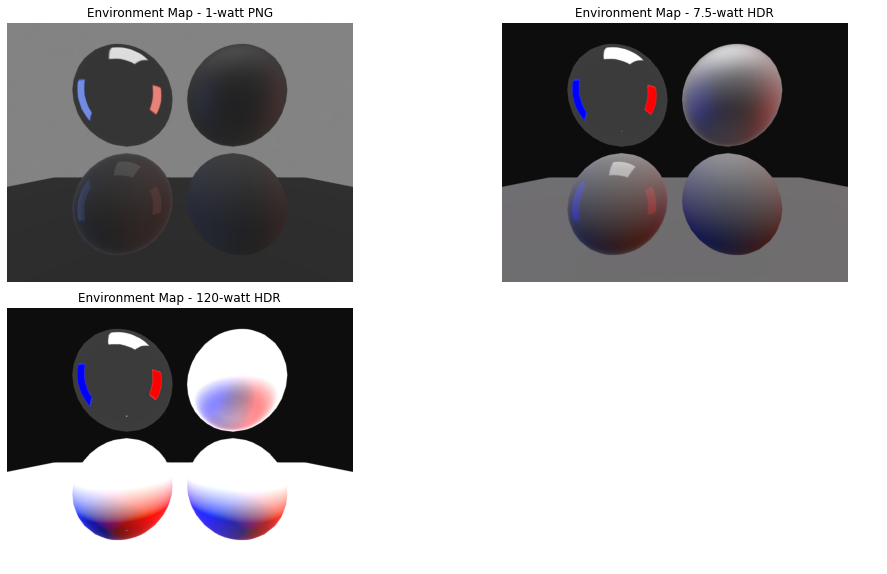

In [36]:
comparator.render()

Although the three images use environment maps with the exact same resolution
and the same *color* values at every pixel, the differences in pixel energy
produces significantly different results.

The 1-watt .png image is both dim and has low contrast (for the reasons
suggested above). The 7.5-watt image contains a larger _range_ of
illumination and leads to a more vibrant image with greater contrast. The
image rendered with the 120-watt image takes this even further.
So far, in fact that the image has become oversaturated and the three of the
four balls have all but disappeared.

Just as we can take a direct light and increase its intensity so much
that the rendered image becomes painfully oversaturated, environment maps
can do the same.

Does this mean that we need to make sure our HDR environment maps have energy
levels within a certain range to prevent image over saturation? No.

<a id="exposure"></a>
#### Tone mapping and exposure

We need to take a brief detour to understand how high dynamic range images get
drawn to your screen (and saved as normalized color maps).

In the images above, the image using the 1-watt .png image has 1/120th the light
energy as the image rendered with the 120-watt environment map. And yet, the
"dim" image is not simply a copy of the bright image with each pixel having
1/120th the value of the original. The dimmer image features smooth contours
on the rough balls that have been washed out in the brighter image. So,
what's happening?

The answer is "tone mapping". It's the process by which an image with
"unbounded" intensity levels gets mapped to an image (or display) with
normalized color. The mapping is not _strictly_ linear.
Generally, near the darkest and brightest features, there is non-linear
tapering in attempt to preserve details at the extremes of illumination.
Furthermore, as the images show above, the tone mapping function has a finite
range -- intensity values outside of that range produce the saturated white
pixels we've seen in some of the previous images.

There are, in fact, various possible mapping functions. 
`RenderEngineVtk` uses the <a href="https://www.kitware.com/pbrj1/">"Generic
Filmic tone mapping operator with the "Uncharted2" parameter values</a>.
There are multiple parameters associated with that operator. To keep things
simple, Drake exposes a single parameter: `exposure`. If you are familiar
with photography, exposure plays a similar role in rendering as it does in
photography. It is essentially a way to control how much
the "film" is exposed to the the scene's radiant energy. Expose it less and the
final image is darker. Expose it more, and the image is brighter. Go too far
in either direction, and the final image can either be a dark mess or a washed
out blur of whiteness. In `RenderEngineVtk`, `exposure` is simply a scale factor
applied to the image prior to performing the non-linear mapping. So, if a
pixel in the resulting image is reflecting 10 W to the camera, an `exposure`
value of 0.5 will mean we map a 5-watt intensity at that pixel. The default
value for `exposure` is 1. Images that are too dark should increase exposure
and images that are too bright should reduce exposure.

It's clear in the above image that the image using the 1-watt .png image is
underexposed (three of the four balls are obviously underlit). At the same
time, the image using the 120-watt .hdr image is overexposed. Let's render
the images again, but this time tune the exposure.

The exposure values below, have been selected so that the _top_ of the
rough, dielectric sphere basically appears the same in all images. (We'll
come back to the question of how do you pick exposure values later.)

In [37]:
def make_config(env_map_path, exposure):
    env_texture = EquirectangularMap(path=env_map_path)
    return {"environment_map": EnvironmentMap(
                                   skybox=True,
                                   texture=env_texture),
            "exposure": exposure,
            # Disable the light; only environment map light in the scene.
            "lights": [LightParameter(intensity=0)]}

comparator.set_render_engines([
    RenderEngineSpec("Increased Exposure - 1-watt PNG", make_config(png_path, 7.5)),
    RenderEngineSpec("Default Exposure - 7.5-watt HDR", make_config(hdr75_path, 1.0)),
    RenderEngineSpec("Decreased Exposure - 120-watt HDR", make_config(hdr1200_path, 0.0833)),
    ])

# Center on the balls, filling the frame.
comparator.pose_camera_once(camera_in_world=[0, -3.5, 2],
                            target_in_world=[0, 0, 2])

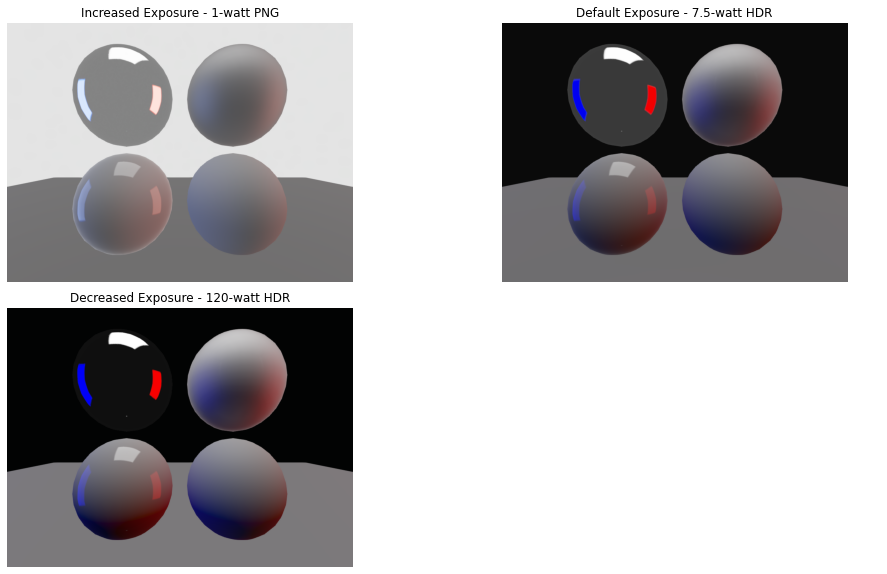

In [38]:
comparator.render()

We can see the effect of exposure on the three images. In all three cases, the
*top* of the rough dielectric ball appears about the same.

While the target ball in the 1-watt image now resembles the ball in the 7.5-watt
image, the other balls and background have changed *significantly*. What happened?
In this case, it's because the "dark" area of the environment map is not true
black. There is a non-zero amount of illumination which has been scaled by a factor
of 7.5, pushing it far enough from black that when the subsequent tone mapping is
applied, "black" has become medium grey. This illustrates an important principle.
If the lighting levels lie within a narrow range, exposure *may not* be sufficient
to increase contrast.

The target ball in the 120-watt image has been pulled back to the same grey as
the 7.5-watt image. It is no longer over saturated and the curvature of the ball
can easily be seen. However, the black in the mirror ball is _darker_ than the
mirror ball in the 7.5-watt image. This is because the 120-watt image has a
larger range. However, the grey background in the 7.5-watt and 120-watt images
has the same energy level. But in the 120-watt image, that amount is much smaller
compared to the maximum intensity. So, when tone mapping is applied, that
background intensity is functionally black and renders as such.

Judicious use of exposure is critical in producing images that are both
aesthetically pleasing as well as modeling sensors which also are sensitive to
exposure.

#### Where do you get environment maps?

The two easiest ways to get environment maps are from downloading or
creating.

Open source environment maps can be downloaded from repositories like
[Polyhaven](https://polyhaven.com/).

The simple environment maps used in this tutorial were created in Blender.
There are copious tutorials on Youtube on how to do this, like
[this one](https://www.youtube.com/watch?v=6YMlMEXsiYU).

<a id="total-illumination"></a>
## Total Illumination

Environment maps can't cast shadows. Direct lights can. A fully-lit scene
can include *both*.

Getting them to work together can be tricky. It's easy to configure lighting
with both environment map and direct lights such that one of the two lighting
sources has no apparent effect.

This typically arises if there is a significant difference between the energy
levels of the direct lights and the environment map.

To get shadows _and_ the benefit of the environment map, it is neccessary to
balance the direct light intensity with the environment. (Failing to do so
would be like trying to use a flashlight to cast shadows outdoors on a sunny
day.)

The images below use a fixed exposure, an environment map, and a downward-pointing
spot light. The scenes differ in the spot light's intensity. At low intensity,
the effect of the light is almost negligible. As the light's intensity increases,
the effect of the light becomes apparent and we get effective shadows. As
the light becomes too powerful, the image becomes oversaturated.

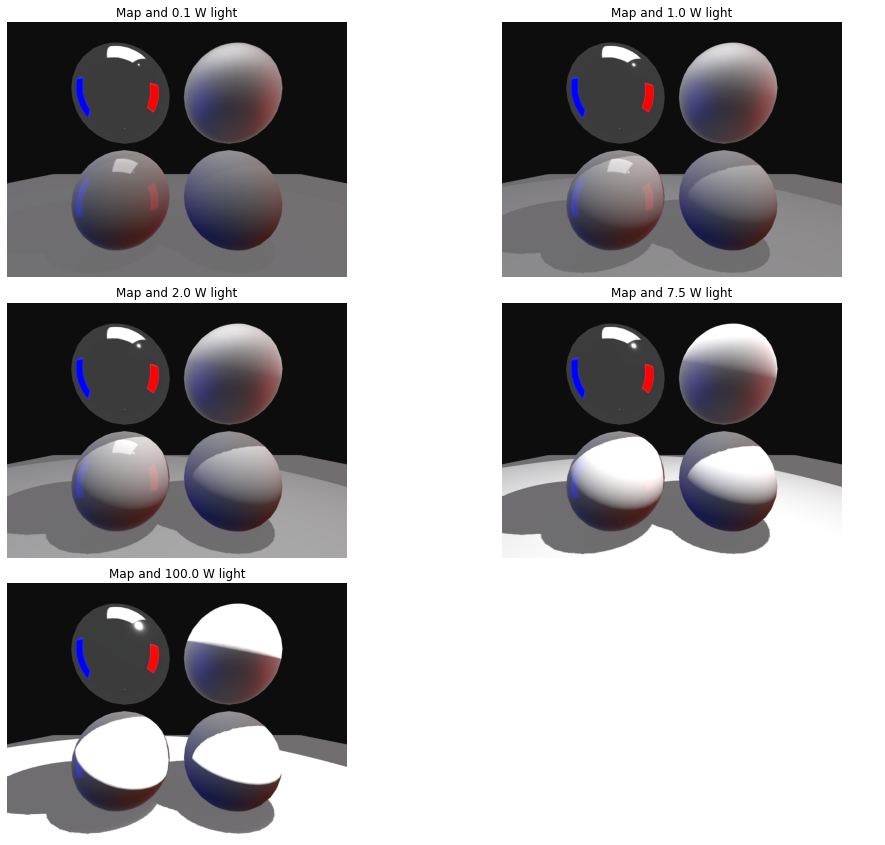

In [39]:
def make_config(intensity):
    env_texture = EquirectangularMap(path=hdr75_path)
    light = LightParameter(type="spot", frame="world",
                           position=[2, -2, 8], cone_angle=40,
                           direction=[-0.25, 0.25, -1],
                           intensity=intensity)
    return {"environment_map": EnvironmentMap(
                                   skybox=True,
                                   texture=env_texture),
            "cast_shadows": True,
            "shadow_map_size": 1024,
            # Disable the light; only environment map light in the scene.
            "lights": [light]}

engines = []
for intensity in [0.1, 1.0, 2.0, 7.5, 100.0]:
    engines.append(RenderEngineSpec(f"Map and {intensity} W light", make_config(intensity)))
comparator.set_render_engines(engines)

# Center on the balls, filling the frame.
comparator.pose_camera_once(camera_in_world=[0, -3.5, 2],
                            target_in_world=[0, 0, 2])

comparator.render()

As we did before with oversaturated images, we'll use `exposure` to reduce
the oversaturation effects. And, as before, we'll use the illumination of the
rough dielectric ball as the guide for choosing the exposure. In this case,
we disabled the shadows while determining those values (as the shadows
interfere with our lighting rubric).

In [40]:
def make_config(intensity, exposure):
    env_texture = EquirectangularMap(path=hdr75_path)
    light = LightParameter(type="spot", frame="world",
                           position=[4, -4, 8], cone_angle=40,
                           direction=[-4, 4, -8],
                           intensity=intensity)
    return {"environment_map": EnvironmentMap(
                                   skybox=True,
                                   texture=env_texture),
            "exposure": exposure,
            "cast_shadows": True,
            "shadow_map_size": 1024,
            "lights": [light]}

engines = []
for intensity, exposure in [(0.1, 0.95),(1.0, 0.55), (2.0, 0.4), (7.5, 0.11), (100.0, 0.0135)]:
    engines.append(RenderEngineSpec(f"Map and {intensity} W light", make_config(intensity, exposure)))
comparator.set_render_engines(engines)

# Center on the balls, filling the frame.
comparator.pose_camera_once(camera_in_world=[0, -3.5, 2],
                            target_in_world=[0, 0, 2])

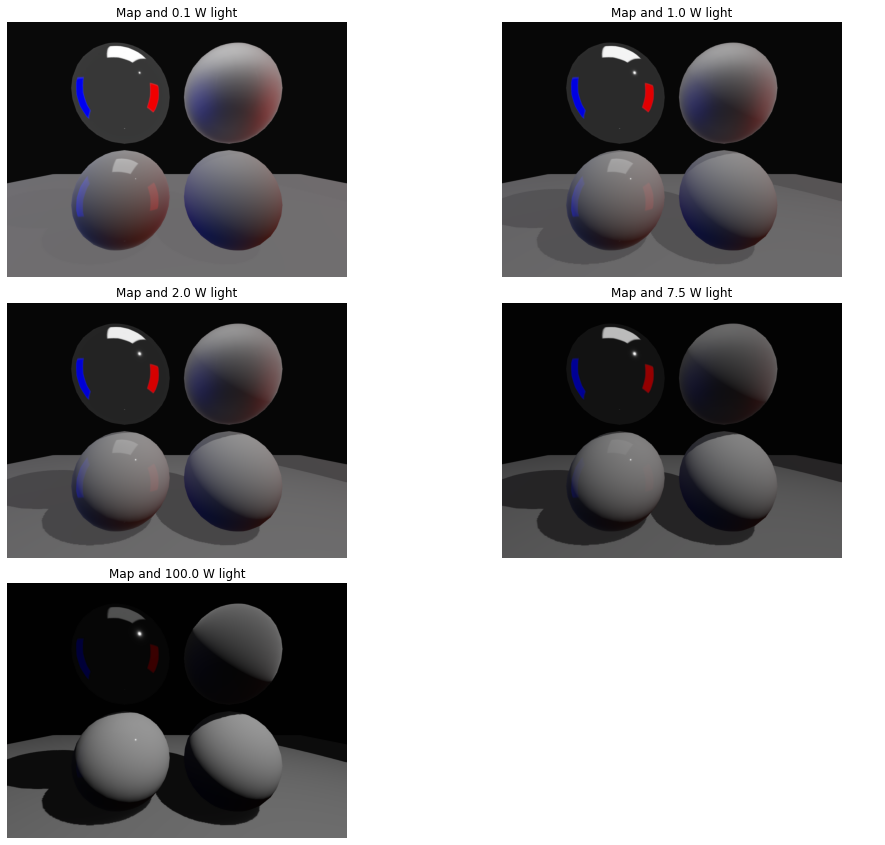

In [41]:
comparator.render()

In all five images, the rough dielectric balls are basically the same.
This has understandbly led to attendendant changes in the other balls.

There are multiple important lessons to draw from the images above.

**Balance**: The images with the 0.1-watt and 100-watt lights show massive
imbalance between the direct lights and the environment map. In the 0.1-watt
image, the spot light has almost no effect (only the faintest of shadows
can be seen below the spheres). In the 100-watt image, the light outshines
the environment map by so much, that the perfect specular reflections
in the smooth metallic ball have been almost entirely eliminated by the
tone mapping. The fundamentally dimmer specular reflections in the smooth
dielectric ball _have_ been elimianted.

In contrast, the 1-watt and 2-watt (and even the 7.5-watt) images show a
better balance between direct illumination and environment map.

**Materials**: The mirror ball is not just perfectly smooth (`roughness` = 0),
but it is also metallic. Metallic materials are unaffected by diffuse light
effects, including from the environment map. The appearance of metallic
surfaces are dominated by specular reflection.

If the material were non-metallic instead, in addition to the specular
reflection attributable to its smoothness, it would also be illuminated by
the diffuse and ambient lights.

However, the two rough spheres (on the right) appear similar. If metallic
balls don't get diffuse light, how is the rough metallic sphere so brightly
illuminated? Does the roughness somehow cause diffuse lighting effects?
No. It is still only specular reflection, but the roughness has caused the
reflection to become so blurred, that it has a diffusive-effect. What you'll
notice if you move the camera, is that the appearance of the rough metallic
ball will change as the camera moves, whereas the rough dielectric ball
remains unchanged.

**Exposure values**: The baseline image uses an image consistently described
in this tutorial as having a "7.5-watt white light". And yet, when we add a
1-watt or 2-watt light to the scene, we have to reduce the exposure to 0.55
and 0.4, respectively. And when we add a 7.5-watt spot light, the exposure
drops all the way down to 0.11 all in the name of normalizing the appearance
of the top of the rough sphere.

Previously, we said that the exposure is simply a scale factor on the surface's
reflected radiant energy. If the environment map has a 7.5-watt top light and
we add another 7.5-watt direct light, why would we have to reduce the exposure
to ten percent of its original value and not simply half? Conversely, by adding
a 1-watt or 2-wat light, we reduced the exposure to around half which implies
that the intensity of the environment on the top of the ball was approximately
1-2 W.

We discussed that the diffuse illumination contributed by the environment
map is the result of finding the average light over the hemisphere associated
with the surface point and normal. The hemisphere is large and the white
light is small (speaking as solid angles). Therefore, the diffuse intensity
is significantly lower than the peak intensity in some portion of the hemisphere.
If the white light were larger, spanning a larger solid angle, more energy
would bleed out as diffuse illumination. In this case, averaging the red, white,
and blue light sources with the dark background produces a peak diffuse
intensity of only about 1-2 watts from the environment map.

This means you can't determine compatible light intensities just by looking
at the peak intensities in the environment map.

So, how do you pick intensity values for your lighting? For now, tinkering.